In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

In [67]:
df = pd.read_csv(filepath_or_buffer='rome_listings_aftereda.csv')

In [68]:
## One Hot encoding for room_type
df = pd.get_dummies(df, columns=['room_type'], prefix='room_type')
df = pd.get_dummies(df, columns=['neighbourhood_cleansed'], prefix='neighbourhood')

In [69]:
## convert boolean columns to int
bool_cols = df.columns[df.dtypes == 'bool']
df[bool_cols] = df[bool_cols].astype(int)

In [70]:
from category_encoders import BinaryEncoder

binary_encoder = BinaryEncoder()
binary_encoder.fit_transform(df['property_type'])
# Create a DataFrame with the new columns
new_columns = pd.DataFrame(binary_encoder.transform(df['property_type']), columns=binary_encoder.get_feature_names_out())

# Concatenate the new columns with the original dataset
df = pd.concat([df, new_columns], axis=1)
df.drop(columns=['property_type'], inplace=True)

In [71]:
price = df.pop('price')

In [72]:
df.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'bathrooms_shared',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'neighbourhood_I Centro Storico', 'neighbourhood_II Parioli/Nomentano',
       'neighbourhood_III Monte Sacro', 'neighbourhood_IV Tiburtina',
       'neighbourhood_IX Eur', 'neighbourhood_V Prenestino/Centocelle',
       'neighbourhood_VI Roma delle Torri',
       'neighbourhood_VII San Giovanni/Cinecittà',
       'neighbourhood_VIII Appia Antica', 'neighbourhood_X Ostia/Acilia',
       'neighbourhood_XI Arvalia/Portuense', 'neighbourhood_XII Monte Verde',
       'neighbourhood_XIII Aurelia', 'neighbourhood_XIV Monte Mario',
       'neighbourhood_XV Cassia/Flaminia', 'property_type_0',
       'property_type_1', 'property_type_2', 'property_type_3',
       'property_type_4', 'property_type_5'],
      dtype='object')

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df, price, test_size=0.3, random_state=42, shuffle=True)

columns_to_standardize = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
scaler = StandardScaler()
X_train[columns_to_standardize] = scaler.fit_transform(X_train[columns_to_standardize])
X_test[columns_to_standardize] = scaler.transform(X_test[columns_to_standardize])

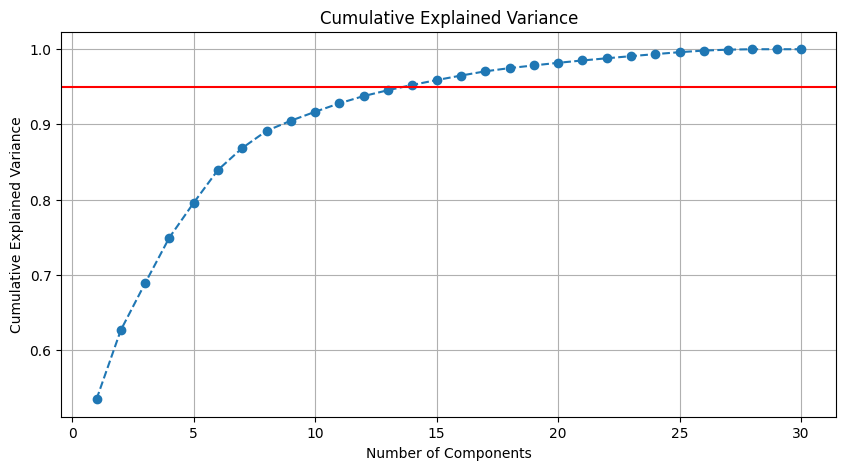

Number of components chosen: 14


In [74]:
# Step 3: Perform PCA
threshold = 0.95
pca = PCA()
pca.fit(X_train)

# Step 4: Calculate explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Step 5: Plot the cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=threshold, color='r', linestyle='-')  # Line for threshold
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Step 6: Determine the number of components

n_components = np.argmax(cumulative_variance >= threshold) + 1
print(f"Number of components chosen: {n_components}")

In [ ]:
pca = PCA(n_components=n_components)
X_train_transform = pca.fit_transform(X_train)
X_test_transform = pca.transform(X_test)

In [ ]:
linear_regression = LinearRegression()
linear_regression.fit(X_train_transform, y_train)
train_predictions = linear_regression.predict(X_train_transform)